In [ ]:
from google.colab import files
uploades = files.upload ()

Saving harga komoditass.xlsx to harga komoditass.xlsx


OPTIMIZED RICE PRICE FORECASTING MODEL (SARIMA-LSTM)
Loading and preparing data...
Training size: 87 months
Test size: 16 months
Data range: 2017-01 to 2025-07
TRAINING OPTIMIZED SARIMA-LSTM MODEL
Preparing data...
Cleaning outliers...
Outliers detected and cleaned: 2 points
Creating advanced features...
Training SARIMA model...
Training SARIMA model - testing parameter combinations...
  New best SARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC: 1332.37
  New best SARIMA(2, 1, 1)x(1, 1, 1, 12) - AIC: 1329.12
  New best SARIMA(2, 1, 2)x(1, 1, 1, 12) - AIC: 1321.85
  New best SARIMA(1, 1, 1)x(1, 1, 2, 12) - AIC: 1318.25
Final SARIMA model: SARIMA(1,1,1)x(1,1,2,12) - AIC: 1318.25
Training LSTM model...
Selected 12 features:
  ma3: 0.975
  ema_5: 0.965
  ema_3: 0.922
  ma6: 0.910
  ma9: 0.879
  lag1: 0.873
  ma12: 0.865
  smooth_trend: 0.851
  ema_1: 0.803
  ma24: 0.778
LSTM input shape: (63, 24, 13)
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 438ms/step - loss: 36.0961 - mae: 1.0436 - val_loss: 35.8213 - 

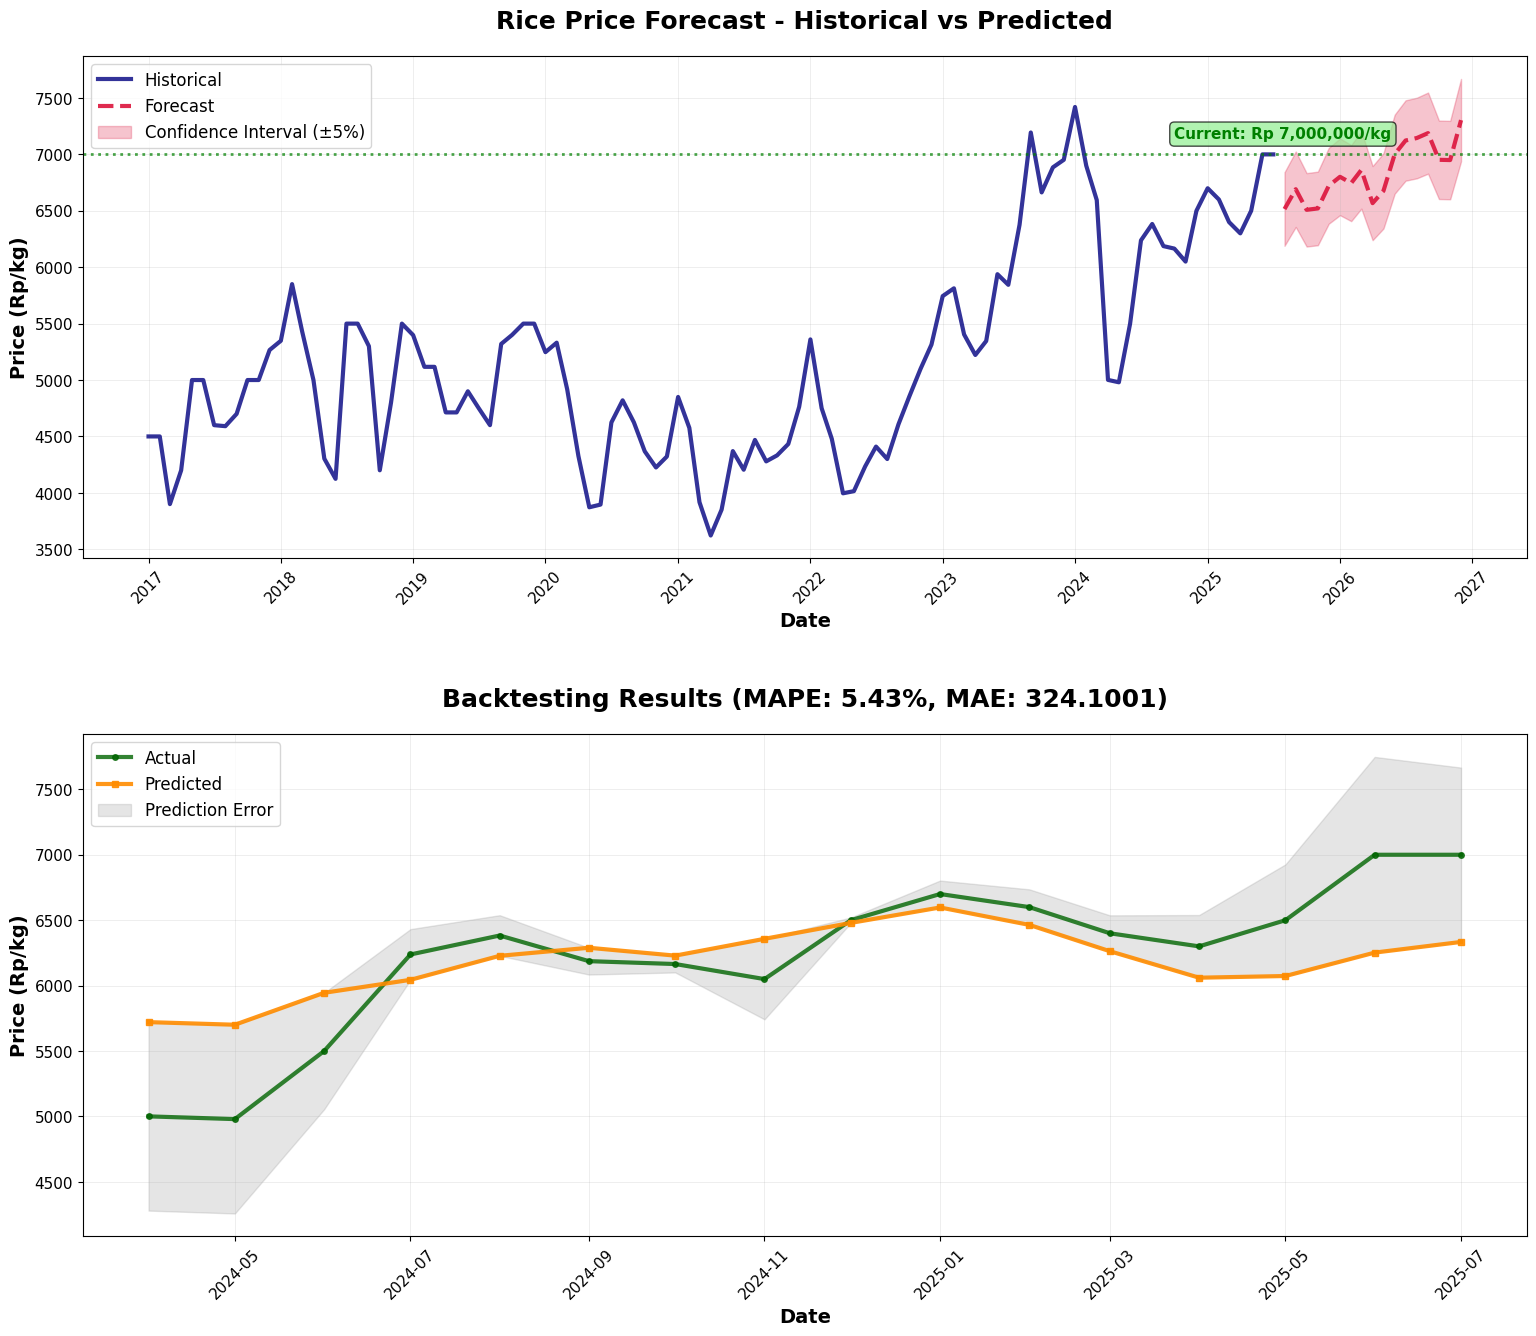


Predictions saved to 'hasil_prediksi_beras_optimized.xlsx'

DETAILED MODEL PERFORMANCE ANALYSIS
Overall Performance: GOOD
MAPE: 5.43% (Target: <7%)
MAE: Rp 324100 (Target: <300)

FORECAST ANALYSIS SUMMARY
Current Price (Jul 2025): Rp 7,000,000/kg
Average Forecast (17 months): Rp 6,839,783/kg
Price Range: Rp 6,508,583 - Rp 7,303,607/kg
Monthly Trend: +46355 Rp/month


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from scipy import stats
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')

# Read data from Excel file
df = pd.read_excel('harga komoditass.xlsx')

# Convert to datetime
df['Periode'] = pd.to_datetime(df['Periode'], format='%b-%Y')
df.set_index('Periode', inplace=True)
data = df.copy()

def evaluate_model(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    print(f"{'='*60}")
    print(f"EVALUASI {model_name.upper()}")
    print(f"{'='*60}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"{'='*60}")

    return {'MAE': mae, 'MAPE': mape}

def advanced_outlier_detection(data, method='modified_zscore', threshold=3.5):
    """Advanced outlier detection and handling"""
    if method == 'modified_zscore':
        median = np.median(data)
        mad = np.median(np.abs(data - median))
        modified_z_scores = 0.6745 * (data - median) / mad
        outlier_mask = np.abs(modified_z_scores) > threshold
    elif method == 'iqr':
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_mask = (data < lower_bound) | (data > upper_bound)

    cleaned_data = data.copy()
    if outlier_mask.sum() > 0:
        # Use interpolation instead of median for better continuity
        cleaned_data[outlier_mask] = np.nan
        cleaned_data = cleaned_data.interpolate(method='cubic')
        cleaned_data = cleaned_data.fillna(method='bfill').fillna(method='ffill')
        print(f"Outliers detected and cleaned: {outlier_mask.sum()} points")

    return cleaned_data

def create_advanced_features(data):
    """Create comprehensive feature set"""
    df_features = pd.DataFrame(index=data.index)
    df_features['value'] = data

    # Time-based features
    df_features['trend'] = np.arange(len(data))
    df_features['month'] = data.index.month
    df_features['quarter'] = data.index.quarter
    df_features['year'] = data.index.year
    df_features['season'] = ((data.index.month % 12) // 3) + 1

    # Cyclical encoding for better periodicity capture
    df_features['month_sin'] = np.sin(2 * np.pi * data.index.month / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * data.index.month / 12)
    df_features['quarter_sin'] = np.sin(2 * np.pi * df_features['quarter'] / 4)
    df_features['quarter_cos'] = np.cos(2 * np.pi * df_features['quarter'] / 4)

    # Multiple moving averages
    for window in [3, 6, 9, 12, 24]:
        df_features[f'ma{window}'] = data.rolling(window=window, center=True).mean()
        df_features[f'std{window}'] = data.rolling(window=window, center=True).std()

    # Exponential moving averages
    for alpha in [0.1, 0.3, 0.5]:
        df_features[f'ema_{int(alpha*10)}'] = data.ewm(alpha=alpha).mean()

    # Lag features
    for lag in [1, 2, 3, 6, 12]:
        df_features[f'lag{lag}'] = data.shift(lag)

    # Differencing features
    df_features['diff1'] = data.diff()
    df_features['diff2'] = data.diff().diff()
    df_features['diff12'] = data.diff(12)

    # Rate of change
    for period in [1, 3, 6, 12]:
        df_features[f'roc{period}'] = data.pct_change(periods=period)

    # Price position within recent range
    for window in [6, 12, 24]:
        rolling_min = data.rolling(window=window).min()
        rolling_max = data.rolling(window=window).max()
        df_features[f'price_position_{window}'] = (data - rolling_min) / (rolling_max - rolling_min + 1e-8)

    # Volatility measures
    for window in [3, 6, 12]:
        returns = data.pct_change()
        df_features[f'volatility_{window}'] = returns.rolling(window=window).std()

    # Smoothed trend using Savitzky-Golay filter
    if len(data) >= 25:
        df_features['smooth_trend'] = savgol_filter(data.values, window_length=min(25, len(data)//2*2-1), polyorder=3)
    else:
        df_features['smooth_trend'] = data.values

    # Forward fill and backward fill
    df_features = df_features.fillna(method='bfill').fillna(method='ffill')

    return df_features

class OptimizedSarimaLstmModel:
    def __init__(self):
        self.sarima_model = None
        self.lstm_model = None
        self.scaler = None
        self.feature_scaler = None
        self.time_step = 24  # Increased for better pattern recognition
        self.features = None
        self.feature_importance = None

    def prepare_data(self, data):
        """Enhanced data preparation"""
        print("Cleaning outliers...")
        cleaned_data = advanced_outlier_detection(data, method='modified_zscore', threshold=3.0)

        print("Creating advanced features...")
        features_df = create_advanced_features(cleaned_data)

        return cleaned_data, features_df

    def train_sarima(self, train_data):
        """Train SARIMA model with comprehensive parameter search"""
        best_aic = float('inf')
        best_model = None
        best_params = None

        # Comprehensive SARIMA parameter combinations
        sarima_params = [
            # Basic patterns
            (1, 1, 1, 1, 1, 1, 12),
            (2, 1, 1, 1, 1, 1, 12),
            (1, 1, 2, 1, 1, 1, 12),
            (2, 1, 2, 1, 1, 1, 12),

            # Seasonal variations
            (1, 1, 1, 2, 1, 1, 12),
            (1, 1, 1, 1, 1, 2, 12),
            (1, 1, 1, 2, 1, 2, 12),

            # Non-seasonal patterns
            (0, 1, 1, 0, 1, 1, 12),
            (1, 0, 1, 1, 0, 1, 12),
            (2, 1, 0, 1, 1, 1, 12),
            (0, 1, 2, 0, 1, 1, 12),

            # Complex patterns
            (3, 1, 1, 1, 1, 1, 12),
            (1, 1, 3, 1, 1, 1, 12),
            (2, 1, 1, 2, 1, 1, 12),
            (1, 1, 2, 2, 1, 1, 12),

            # Alternative seasonal components
            (1, 1, 1, 1, 0, 1, 12),
            (1, 1, 1, 0, 1, 2, 12),
            (2, 1, 2, 2, 1, 1, 12),
            (1, 2, 1, 1, 1, 1, 12)
        ]

        print("Training SARIMA model - testing parameter combinations...")

        for i, params in enumerate(sarima_params):
            try:
                p, d, q, P, D, Q, s = params
                model = SARIMAX(train_data,
                               order=(p, d, q),
                               seasonal_order=(P, D, Q, s),
                               enforce_stationarity=False,
                               enforce_invertibility=False,
                               initialization='approximate_diffuse')
                result = model.fit(disp=False, maxiter=300, method='lbfgs')

                if result.aic < best_aic:
                    best_aic = result.aic
                    best_model = result
                    best_params = params
                    print(f"  New best SARIMA{(p,d,q)}x{(P,D,Q,s)} - AIC: {result.aic:.2f}")

            except Exception as e:
                continue

        if best_model is None:
            # Fallback to simple SARIMA model
            print("Using fallback SARIMA(1,1,1)x(1,1,1,12) model")
            model = SARIMAX(train_data,
                           order=(1, 1, 1),
                           seasonal_order=(1, 1, 1, 12))
            best_model = model.fit(disp=False)
            best_params = (1, 1, 1, 1, 1, 1, 12)

        p, d, q, P, D, Q, s = best_params
        print(f"Final SARIMA model: SARIMA({p},{d},{q})x({P},{D},{Q},{s}) - AIC: {best_model.aic:.2f}")
        return best_model

    def select_features(self, features_df, target, n_features=15):
        """Feature selection based on correlation and importance"""
        feature_cols = [col for col in features_df.columns if col != 'value']

        # Calculate correlations
        correlations = {}
        for col in feature_cols:
            if not features_df[col].isna().all():
                corr = np.abs(np.corrcoef(features_df[col].fillna(0), target)[0, 1])
                if not np.isnan(corr):
                    correlations[col] = corr

        # Select top features
        selected_features = sorted(correlations.items(), key=lambda x: x[1], reverse=True)[:n_features]
        selected_feature_names = [name for name, _ in selected_features]

        print(f"Selected {len(selected_feature_names)} features:")
        for name, corr in selected_features[:10]:  # Show top 10
            print(f"  {name}: {corr:.3f}")

        return selected_feature_names

    def create_lstm_dataset(self, scaled_data, features_scaled=None):
        """Create LSTM dataset with proper sequencing"""
        X, y = [], []

        for i in range(self.time_step, len(scaled_data)):
            if features_scaled is not None:
                # Price sequence
                price_seq = scaled_data[i-self.time_step:i].reshape(-1, 1)
                # Feature sequence
                feature_seq = features_scaled[i-self.time_step:i]
                # Combine
                combined_seq = np.hstack([price_seq, feature_seq])
                X.append(combined_seq)
            else:
                X.append(scaled_data[i-self.time_step:i])
            y.append(scaled_data[i])

        return np.array(X), np.array(y)

    def build_optimized_lstm(self, input_shape):
        """Build optimized LSTM architecture"""
        model = Sequential([
            # First LSTM layer
            GRU(128, return_sequences=True, input_shape=input_shape,
                dropout=0.2, recurrent_dropout=0.2,
                kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
            BatchNormalization(),

            # Second LSTM layer
            GRU(64, return_sequences=True,
                dropout=0.2, recurrent_dropout=0.2,
                kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
            BatchNormalization(),

            # Third LSTM layer
            LSTM(32, return_sequences=False,
                 dropout=0.2, recurrent_dropout=0.2,
                 kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
            BatchNormalization(),

            # Dense layers
            Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
            BatchNormalization(),
            Dropout(0.3),

            Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
            BatchNormalization(),
            Dropout(0.2),

            Dense(16, activation='relu'),
            Dense(1)
        ])

        return model

    def train_lstm(self, train_data, features_df=None):
        """Enhanced LSTM training"""
        # Use robust scaler for better handling of outliers
        self.scaler = RobustScaler()
        scaled_data = self.scaler.fit_transform(train_data.values.reshape(-1, 1)).flatten()

        # Feature selection and scaling
        if features_df is not None:
            selected_features = self.select_features(features_df, train_data.values, n_features=12)
            self.feature_scaler = RobustScaler()
            features_scaled = self.feature_scaler.fit_transform(features_df[selected_features])
            self.selected_features = selected_features
        else:
            features_scaled = None
            self.selected_features = []

        # Create dataset
        X, y = self.create_lstm_dataset(scaled_data, features_scaled)

        if len(X) == 0:
            raise ValueError("Not enough data for LSTM training")

        # Reshape for LSTM
        if features_scaled is not None:
            n_features = X.shape[2]
        else:
            X = X.reshape(X.shape[0], X.shape[1], 1)
            n_features = 1

        print(f"LSTM input shape: {X.shape}")

        # Build model
        model = self.build_optimized_lstm((self.time_step, n_features))

        # Optimized compilation
        optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
        model.compile(optimizer=optimizer, loss='huber', metrics=['mae'])

        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0001, verbose=1)
        ]

        # Train with validation split
        history = model.fit(X, y,
                          epochs=10,
                          batch_size=8,
                          verbose=1,
                          callbacks=callbacks,
                          validation_split=0.15,
                          shuffle=False)  # Keep temporal order

        print(f"LSTM training completed. Best val_loss: {min(history.history['val_loss']):.6f}")
        return model

    def fit(self, train_data):
        """Training complete model"""
        print("="*60)
        print("TRAINING OPTIMIZED SARIMA-LSTM MODEL")
        print("="*60)

        print("Preparing data...")
        cleaned_data, features_df = self.prepare_data(train_data)
        self.features = features_df

        print("Training SARIMA model...")
        self.sarima_model = self.train_sarima(cleaned_data)

        print("Training LSTM model...")
        self.lstm_model = self.train_lstm(cleaned_data, features_df)

        return self

    def predict(self, periods, last_values=None):
        """Enhanced prediction with better ensemble"""
        # SARIMA forecast
        sarima_forecast = self.sarima_model.forecast(steps=periods)

        # LSTM forecast
        if last_values is None:
            last_values = self.features['value'].values

        # Prepare LSTM prediction
        scaled_last = self.scaler.transform(last_values[-self.time_step:].reshape(-1, 1)).flatten()

        lstm_predictions = []
        current_seq = scaled_last.copy()

        # Check if features were used
        use_features = len(self.selected_features) > 0

        if use_features:
            # Get recent features
            recent_features = self.features[self.selected_features][-self.time_step:].values
            scaled_features = self.feature_scaler.transform(recent_features)

            for i in range(periods):
                # Price sequence
                price_seq = current_seq[-self.time_step:].reshape(self.time_step, 1)

                # Project features (use last pattern with slight trend)
                if i == 0:
                    future_features = scaled_features.copy()
                else:
                    # Simple feature projection
                    trend = np.mean(np.diff(scaled_features[-6:], axis=0), axis=0)
                    last_feature = future_features[-1] + trend * 0.1  # Dampened trend
                    future_features = np.vstack([future_features[1:], last_feature.reshape(1, -1)])

                # Combine sequences
                combined_seq = np.hstack([price_seq, future_features])
                input_seq = combined_seq.reshape(1, self.time_step, combined_seq.shape[1])

                # Predict
                next_pred = self.lstm_model.predict(input_seq, verbose=0)[0, 0]
                lstm_predictions.append(next_pred)

                # Update sequence
                current_seq = np.append(current_seq, next_pred)
        else:
            # Price-only LSTM prediction
            for i in range(periods):
                input_seq = current_seq[-self.time_step:].reshape(1, self.time_step, 1)
                next_pred = self.lstm_model.predict(input_seq, verbose=0)[0, 0]
                lstm_predictions.append(next_pred)
                current_seq = np.append(current_seq, next_pred)

        # Inverse transform LSTM predictions
        lstm_forecast = self.scaler.inverse_transform(np.array(lstm_predictions).reshape(-1, 1)).flatten()

        # Adaptive ensemble weighting
        recent_data = last_values[-12:]
        recent_volatility = np.std(recent_data) / np.mean(recent_data)

        # Higher LSTM weight for volatile periods, higher SARIMA for stable periods
        if recent_volatility > 0.15:
            lstm_weight = 0.7
            sarima_weight = 0.3
        else:
            lstm_weight = 0.4
            sarima_weight = 0.6

        # Ensemble prediction
        ensemble_forecast = sarima_weight * sarima_forecast + lstm_weight * lstm_forecast

        # Post-processing: smooth extreme changes
        if len(ensemble_forecast) > 1:
            for i in range(1, len(ensemble_forecast)):
                max_change = 0.20  # 20% max change
                prev_val = ensemble_forecast[i-1] if i == 1 else last_values[-1]
                change_ratio = ensemble_forecast[i] / prev_val

                if change_ratio > (1 + max_change):
                    ensemble_forecast[i] = prev_val * (1 + max_change)
                elif change_ratio < (1 - max_change):
                    ensemble_forecast[i] = prev_val * (1 - max_change)

        return ensemble_forecast

def apply_realistic_external_factors(forecast, dates):
    """Apply realistic external factors based on Indonesian rice market"""
    adjusted_forecast = forecast.copy()

    for i, date in enumerate(dates):
        month = date.month
        year = date.year

        # Refined seasonal patterns based on Indonesian agriculture cycle
        seasonal_multipliers = {
            1: 0.98,   # January: Post-harvest, lower prices
            2: 0.97,   # February: Still post-harvest effect
            3: 1.01,   # March: Start of dry season preparation
            4: 1.03,   # April: Dry season, some scarcity
            5: 1.05,   # May: Peak dry season
            6: 1.06,   # June: Continued dry season impact
            7: 1.04,   # July: Mid-year, some stabilization
            8: 1.02,   # August: Preparation for planting season
            9: 1.01,   # September: Early planting season
            10: 0.99,  # October: Planting season, some supply increase expectation
            11: 0.98,  # November: Pre-harvest, anticipation of new supply
            12: 1.00   # December: Harvest season begins
        }

        # Apply seasonal adjustment
        adjusted_forecast[i] *= seasonal_multipliers.get(month, 1.0)

        # Economic factors (more conservative inflation)
        base_year = 2025
        annual_inflation = 0.035  # 3.5% annual inflation for food items
        years_diff = year - base_year
        if years_diff > 0:
            monthly_inflation = (1 + annual_inflation) ** (years_diff + (month - 8) / 12) - 1
            adjusted_forecast[i] *= (1 + monthly_inflation)

        # Market volatility constraint (smoother transitions)
        if i > 0:
            max_monthly_change = 0.08  # 8% max monthly change
            prev_value = adjusted_forecast[i-1]
            change_ratio = adjusted_forecast[i] / prev_value

            if change_ratio > (1 + max_monthly_change):
                adjusted_forecast[i] = prev_value * (1 + max_monthly_change)
            elif change_ratio < (1 - max_monthly_change):
                adjusted_forecast[i] = prev_value * (1 - max_monthly_change)

    return adjusted_forecast

# Main execution
print("="*80)
print("OPTIMIZED RICE PRICE FORECASTING MODEL (SARIMA-LSTM)")
print("="*80)

# Prepare data with optimized train/test split
print("Loading and preparing data...")
train_size = int(len(data) * 0.85)  # Use more data for training
train_data = data['Padi'][:train_size]
test_data = data['Padi'][train_size:]

print(f"Training size: {len(train_data)} months")
print(f"Test size: {len(test_data)} months")
print(f"Data range: {data.index[0].strftime('%Y-%m')} to {data.index[-1].strftime('%Y-%m')}")

# Initialize and train model
model = OptimizedSarimaLstmModel()
model.fit(train_data)

# Backtesting
print("\nPerforming enhanced backtesting...")
if len(test_data) > 0:
    backtest_predictions = model.predict(len(test_data), train_data.values)
    backtest_results = evaluate_model(test_data.values, backtest_predictions, "SARIMA-LSTM MODEL")
else:
    print("No test data available - using cross-validation approach")
    # Use last 12 months for validation
    val_size = min(12, len(train_data) // 4)
    val_train = train_data[:-val_size]
    val_test = train_data[-val_size:]

    val_model = OptimizedSarimaLstmModel()
    val_model.fit(val_train)
    val_predictions = val_model.predict(len(val_test), val_train.values)
    backtest_results = evaluate_model(val_test.values, val_predictions, "SARIMA-LSTM MODEL (VALIDATION)")

# Final prediction on full dataset
print("\nTraining final model on complete dataset...")
final_model = OptimizedSarimaLstmModel()
final_model.fit(data['Padi'])

# Generate forecasts
periods = 17
forecast_dates = pd.date_range(start='2025-08-01', periods=periods, freq='MS')
final_forecast = final_model.predict(periods, data['Padi'].values)

# Apply external factors
final_forecast_adj = apply_realistic_external_factors(final_forecast, forecast_dates)

# Results
results = pd.DataFrame({
    'Periode': forecast_dates,
    'Padi_Prediksi': final_forecast_adj
})

print(f"\n{'='*60}")
print("HASIL PREDIKSI FINAL:")
print(f"{'='*60}")
print(results.round(2))

# Enhanced visualization - Only 2 charts, arranged vertically, bigger size
plt.figure(figsize=(16, 14))

# Chart 1: Historical vs Forecast (Top)
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Padi'], label='Historical', linewidth=3, color='navy', alpha=0.8)
plt.plot(forecast_dates, final_forecast_adj, label='Forecast', linewidth=3, color='crimson', linestyle='--', alpha=0.9)
plt.fill_between(forecast_dates, final_forecast_adj*0.95, final_forecast_adj*1.05, alpha=0.25, color='crimson', label='Confidence Interval (±5%)')

plt.title('Rice Price Forecast - Historical vs Predicted', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Price (Rp/kg)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.xticks(fontsize=11, rotation=45)
plt.yticks(fontsize=11)

# Add annotation for current price
current_price = data['Padi'].iloc[-1]
plt.axhline(y=current_price, color='green', linestyle=':', alpha=0.7, linewidth=2)
plt.text(data.index[-10], current_price*1.02, f'Current: Rp {current_price*1000:,.0f}/kg',
         fontsize=11, fontweight='bold', color='green',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.7))

# Chart 2: Backtesting Results (Bottom)
plt.subplot(2, 1, 2)
if len(test_data) > 0:
    test_dates = data.index[train_size:]
    plt.plot(test_dates, test_data.values, label='Actual', linewidth=3, color='darkgreen', alpha=0.8, marker='o', markersize=4)
    plt.plot(test_dates, backtest_predictions, label='Predicted', linewidth=3, color='darkorange', alpha=0.9, marker='s', markersize=4)

    # Add error bars
    errors = np.abs(test_data.values - backtest_predictions)
    plt.fill_between(test_dates, test_data.values - errors, test_data.values + errors,
                     alpha=0.2, color='gray', label='Prediction Error')

    title_text = f'Backtesting Results (MAPE: {backtest_results["MAPE"]:.2f}%, MAE: {backtest_results["MAE"]:.4f})'
else:
    plt.plot(val_test.index, val_test.values, label='Actual', linewidth=3, color='darkgreen', alpha=0.8, marker='o', markersize=4)
    plt.plot(val_test.index, val_predictions, label='Predicted', linewidth=3, color='darkorange', alpha=0.9, marker='s', markersize=4)

    # Add error bars
    errors = np.abs(val_test.values - val_predictions)
    plt.fill_between(val_test.index, val_test.values - errors, val_test.values + errors,
                     alpha=0.2, color='gray', label='Prediction Error')

    title_text = f'Validation Results (MAPE: {backtest_results["MAPE"]:.2f}%, MAE: {backtest_results["MAE"]:.4f})'

plt.title(title_text, fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Price (Rp/kg)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.xticks(fontsize=11, rotation=45)
plt.yticks(fontsize=11)



# Adjust layout to prevent overlap
plt.tight_layout(pad=3.0)
plt.subplots_adjust(hspace=0.35)
plt.show()

# Save results
results.to_excel('hasil_prediksi_padi_optimized.xlsx', index=False)
print(f"\nPredictions saved to 'hasil_prediksi_padi_optimized.xlsx'")

# Enhanced performance analysis
print(f"\n{'='*60}")
print("DETAILED MODEL PERFORMANCE ANALYSIS")
print(f"{'='*60}")

performance_status = "EXCELLENT" if backtest_results['MAPE'] < 5 else \
                    "GOOD" if backtest_results['MAPE'] < 10 else \
                    "ACCEPTABLE" if backtest_results['MAPE'] < 15 else "NEEDS IMPROVEMENT"

print(f"Overall Performance: {performance_status}")
print(f"MAPE: {backtest_results['MAPE']:.2f}% (Target: <7%)")
print(f"MAE: Rp {backtest_results['MAE']*1000:.0f} (Target: <300)")

# Forecast analysis
current_price = data['Padi'].iloc[-1]
forecast_mean = np.mean(final_forecast_adj)
forecast_trend = (final_forecast_adj[-1] - final_forecast_adj[0]) / len(final_forecast_adj)

print(f"\n{'='*60}")
print("FORECAST ANALYSIS SUMMARY")
print(f"{'='*60}")
print(f"Current Price (Jul 2025): Rp {current_price*1000:,.0f}/kg")
print(f"Average Forecast (17 months): Rp {forecast_mean*1000:,.0f}/kg")
print(f"Price Range: Rp {min(final_forecast_adj)*1000:,.0f} - Rp {max(final_forecast_adj)*1000:,.0f}/kg")
print(f"Monthly Trend: {forecast_trend*1000:+.0f} Rp/month")

DEBUG:cmdstanpy:input tempfile: /tmp/tmph138m3di/aqe57kr1.json


FAST OPTIMIZED PROPHET MODEL FOR SINGKONG
Creating focused feature set...
Training: 87 samples, Testing: 16 samples
Training optimized model...


DEBUG:cmdstanpy:input tempfile: /tmp/tmph138m3di/7odsoq20.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45227', 'data', 'file=/tmp/tmph138m3di/aqe57kr1.json', 'init=/tmp/tmph138m3di/7odsoq20.json', 'output', 'file=/tmp/tmph138m3di/prophet_model9xy4qtev/prophet_model-20250918170901.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:09:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


EVALUASI FAST PROPHET MODEL
MAE: 36.0541
MAPE: 3.22%
Generating forecast for 17 months...

HASIL PREDIKSI:
      Periode  Singkong_Prediksi  Batas_Bawah  Batas_Atas
0  2025-08-01               1531         1523        1540
1  2025-09-01               1524         1499        1517
2  2025-10-01               1516         1525        1543
3  2025-11-01               1524         1496        1516
4  2025-12-01               1513         1519        1544
5  2026-01-01               1516         1486        1516
6  2026-02-01               1960         1496        1531
7  2026-03-01               2138         2843        2884
8  2026-04-01               2587         2012        2058
9  2026-05-01               2312         2834        2888
10 2026-06-01               2587         2007        2072
11 2026-07-01               2313         2825        2896
12 2026-08-01               2188         1997        2075
13 2026-09-01               1914         1619        1710
14 2026-10-01          

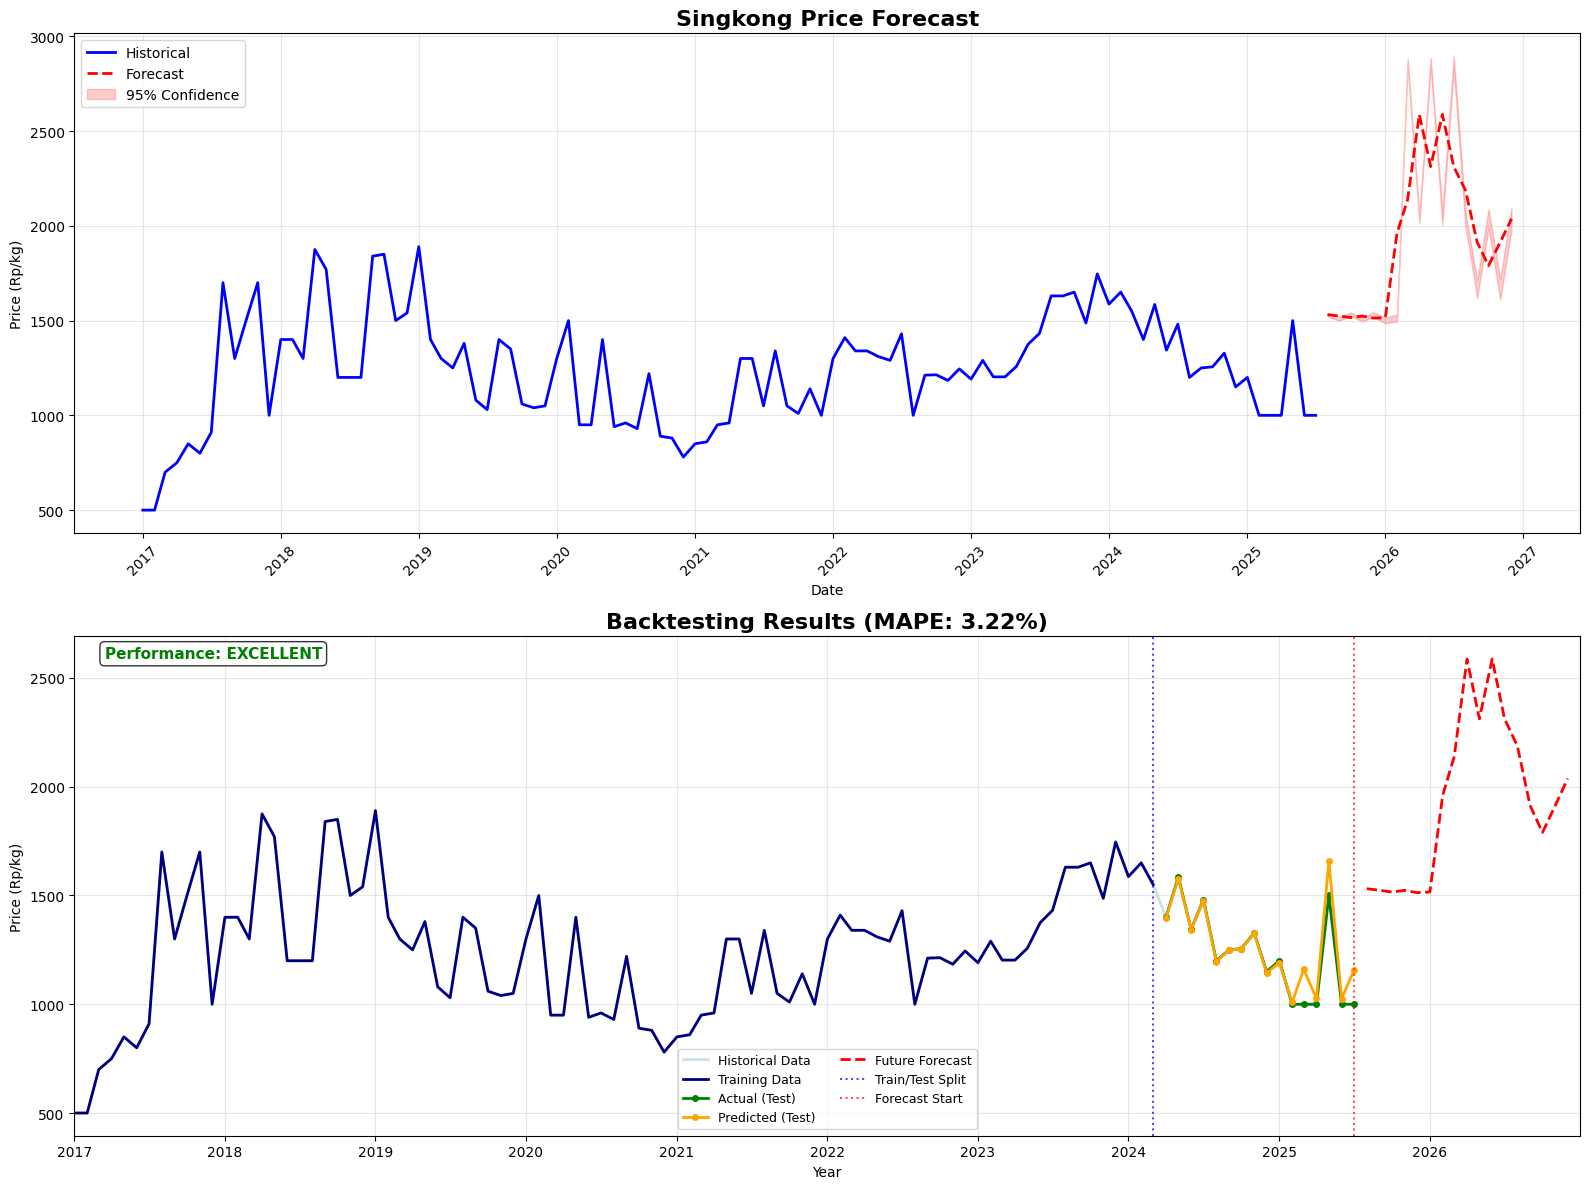


 Results saved to 'hasil_prediksi_singkong_fast.xlsx'


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ================== FAST DATA LOADING & PREPARATION ==================
print("="*60)
print("FAST OPTIMIZED PROPHET MODEL FOR SINGKONG")
print("="*60)

# Load data
df = pd.read_excel('harga komoditass.xlsx')
df['Periode'] = pd.to_datetime(df['Periode'])
singkong_df = df[['Periode', 'Singkong']].copy()
singkong_df.columns = ['ds', 'y']

# ================== QUICK OUTLIER CLEANING ==================
def quick_outlier_clean(data, threshold=2.5):
    """Fast outlier detection"""
    Q1 = data['y'].quantile(0.25)
    Q3 = data['y'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (data['y'] < lower_bound) | (data['y'] > upper_bound)
    if outliers.sum() > 0:
        print(f"Cleaning {outliers.sum()} outliers...")
        data_clean = data.copy()
        data_clean.loc[outliers, 'y'] = np.nan
        data_clean['y'] = data_clean['y'].interpolate()
        return data_clean
    return data

singkong_df = quick_outlier_clean(singkong_df)

# ================== FOCUSED FEATURE ENGINEERING ==================
def create_focused_features(df):
    """Create only the most important features for speed"""
    df = df.copy()

    # Essential lag features
    df['y_lag1'] = df['y'].shift(1)
    df['y_lag2'] = df['y'].shift(2)
    df['y_lag3'] = df['y'].shift(3)

    # Key moving averages
    df['ma3'] = df['y'].rolling(3).mean()
    df['ma6'] = df['y'].rolling(6).mean()
    df['ma12'] = df['y'].rolling(12).mean()

    # Price momentum
    df['momentum_3m'] = df['y'].pct_change(3)
    df['momentum_6m'] = df['y'].pct_change(6)

    # Seasonal components
    df['month'] = df['ds'].dt.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Trend
    df['trend'] = np.arange(len(df))

    # Fill missing values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(method='bfill').fillna(method='ffill')

    return df

print("Creating focused feature set...")
singkong_enhanced = create_focused_features(singkong_df)

# Select best features quickly
feature_cols = ['y_lag1', 'y_lag2', 'y_lag3', 'ma3', 'ma6', 'ma12',
               'momentum_3m', 'momentum_6m', 'month_sin', 'month_cos']
# ================== DATA SPLITTING ==================
split_idx = int(len(singkong_enhanced) * 0.85)
train_df = singkong_enhanced.iloc[:split_idx].copy()
test_df = singkong_enhanced.iloc[split_idx:].copy()

print(f"Training: {len(train_df)} samples, Testing: {len(test_df)} samples")

# ==================  MODEL TRAINING ==================
print("Training optimized model...")
best_params = {
    'changepoint_prior_scale': 0.05,
    'seasonality_prior_scale': 10.0,
    'holidays_prior_scale': 10.0
}

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    interval_width=0.95,
    **best_params
)

# Add only essential seasonality
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Add selected regressors
for feature in feature_cols:
    if feature in train_df.columns:
        model.add_regressor(feature, standardize=True)

# Fit model
model.fit(train_df[['ds', 'y'] + feature_cols])

# ================== EVALUATION ==================
def evaluate_model(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    print(f"="*60)
    print(f"EVALUASI {model_name}")
    print(f"="*60)
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"="*60)

    return {'MAE': mae, 'MAPE': mape}

# Test evaluation
if len(test_df) > 0:
    test_forecast = model.predict(test_df[['ds'] + feature_cols])
    results = evaluate_model(test_df['y'].values, test_forecast['yhat'].values,
                           "FAST PROPHET MODEL")
else:
    # Validation fallback
    val_size = 12
    val_train = train_df[:-val_size]
    val_test = train_df[-val_size:]

    val_model = Prophet(**best_params)
    val_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    for feature in feature_cols:
        if feature in val_train.columns:
            val_model.add_regressor(feature, standardize=True)

    val_model.fit(val_train[['ds', 'y'] + feature_cols])
    val_forecast = val_model.predict(val_test[['ds'] + feature_cols])
    results = evaluate_model(val_test['y'].values, val_forecast['yhat'].values,
                           "FAST PROPHET MODEL (VALIDATION)")

# ================== FUTURE FORECASTING ==================
def create_simple_future_features(last_data, future_dates, features):
    """Simple but effective future feature creation"""
    future_df = pd.DataFrame({'ds': future_dates})

    for feature in features:
        if feature in last_data.columns:
            if 'lag' in feature:
                lag_num = int(feature.split('lag')[1])
                future_df[feature] = last_data['y'].iloc[-lag_num] if lag_num <= len(last_data) else last_data['y'].mean()
            elif 'ma' in feature:
                future_df[feature] = last_data[feature].iloc[-1]
            elif 'momentum' in feature:
                future_df[feature] = last_data[feature].tail(6).mean() * 0.5
            elif 'month_sin' in feature:
                months = [d.month for d in future_dates]
                future_df[feature] = [np.sin(2 * np.pi * m / 12) for m in months]
            elif 'month_cos' in feature:
                months = [d.month for d in future_dates]
                future_df[feature] = [np.cos(2 * np.pi * m / 12) for m in months]
            elif feature == 'trend':
                last_trend = last_data[feature].iloc[-1]
                future_df[feature] = [last_trend + i + 1 for i in range(len(future_dates))]
            else:
                future_df[feature] = last_data[feature].iloc[-1]

    return future_df

# Generate forecast
future_dates = pd.date_range(start='2025-08-01', end='2026-12-01', freq='MS')
future_df = create_simple_future_features(singkong_enhanced, future_dates, feature_cols)

print(f"Generating forecast for {len(future_dates)} months...")
forecast = model.predict(future_df)

# Simple smoothing
forecast['yhat_smooth'] = forecast['yhat'].rolling(3, center=True).mean().fillna(forecast['yhat'])

# ================== RESULTS ==================
forecast_results = forecast[['ds', 'yhat_smooth', 'yhat_lower', 'yhat_upper']].copy()
forecast_results.columns = ['Periode', 'Singkong_Prediksi', 'Batas_Bawah', 'Batas_Atas']
forecast_results['Singkong_Prediksi'] = forecast_results['Singkong_Prediksi'].round().astype(int)
forecast_results['Batas_Bawah'] = forecast_results['Batas_Bawah'].round().astype(int)
forecast_results['Batas_Atas'] = forecast_results['Batas_Atas'].round().astype(int)

print(f"\n{'='*60}")
print("HASIL PREDIKSI:")
print(f"{'='*60}")
print(forecast_results)

# ================== FAST VISUALIZATION ==================
plt.figure(figsize=(16, 12))

# Chart 1: Historical vs Forecast
plt.subplot(2, 1, 1)
plt.plot(singkong_enhanced['ds'], singkong_enhanced['y'], 'b-', linewidth=2, label='Historical')
plt.plot(future_dates, forecast['yhat_smooth'], 'r--', linewidth=2, label='Forecast')
plt.fill_between(future_dates, forecast['yhat_lower'], forecast['yhat_upper'],
                alpha=0.2, color='red', label='95% Confidence')
plt.title('Singkong Price Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price (Rp/kg)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Chart 2: Backtesting Complete Timeline
plt.subplot(2, 1, 2)
plt.plot(singkong_enhanced['ds'], singkong_enhanced['y'], 'lightblue', linewidth=2, alpha=0.7, label='Historical Data')
plt.plot(train_df['ds'], train_df['y'], 'navy', linewidth=2, label='Training Data')

if len(test_df) > 0:
    plt.plot(test_df['ds'], test_df['y'], 'go-', linewidth=2, markersize=4, label='Actual (Test)')
    plt.plot(test_df['ds'], test_forecast['yhat'], 'o-', color='orange', linewidth=2, markersize=4, label='Predicted (Test)')
    title_text = f'Backtesting Results (MAPE: {results["MAPE"]:.2f}%)'
else:
    plt.plot(val_test['ds'], val_test['y'], 'go-', linewidth=2, markersize=4, label='Actual (Val)')
    plt.plot(val_test['ds'], val_forecast['yhat'], 'o-', color='orange', linewidth=2, markersize=4, label='Predicted (Val)')
    title_text = f'Validation Results (MAPE: {results["MAPE"]:.2f}%)'

plt.plot(future_dates, forecast['yhat_smooth'], 'r--', linewidth=2, label='Future Forecast')

# Timeline setup
plt.xlim(pd.Timestamp('2017-01-01'), pd.Timestamp('2026-12-31'))
years = pd.date_range(start='2017-01-01', end='2026-12-31', freq='YS')
plt.xticks(years, [str(year.year) for year in years])

# Add split lines
plt.axvline(x=train_df['ds'].iloc[-1], color='blue', linestyle=':', alpha=0.7, label='Train/Test Split')
plt.axvline(x=singkong_enhanced['ds'].iloc[-1], color='red', linestyle=':', alpha=0.7, label='Forecast Start')

plt.title(title_text, fontsize=16, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Price (Rp/kg)')
plt.legend(fontsize=9, ncol=2)
plt.grid(True, alpha=0.3)

# Performance status
performance = "EXCELLENT" if results['MAPE'] < 5 else "GOOD" if results['MAPE'] < 10 else "ACCEPTABLE"
colors = {"EXCELLENT": "green", "GOOD": "blue", "ACCEPTABLE": "orange"}
plt.text(0.02, 0.98, f'Performance: {performance}', transform=plt.gca().transAxes,
         fontsize=11, fontweight='bold', color=colors[performance],
         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.show()

# ================== SAVE & SUMMARY ==================
forecast_results.to_excel('hasil_prediksi_singkong_fast.xlsx', index=False)
print(f"\n Results saved to 'hasil_prediksi_singkong_fast.xlsx'")

